In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.autograd import Function
import torchvision
import torchvision.transforms as transforms
from torchvision import models
%matplotlib inline
import matplotlib.pyplot as plt
import os
import argparse
import cv2
from torch import topk
from PIL import Image
from matplotlib.pyplot import imshow


In [3]:
def imageshow(img):
    npimg = img.cpu().numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # batch_size : 64
        # Input size to the Autoencoder : [batch_size, 3, 32, 32]
        # Output size from the Autoencoder : [batch_size, 3, 32, 32]
        self.encoder = nn.Sequential(
            # 3 input channels(RGB), 12 output channels, 3x3 square convolution
            nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, stride=1, padding=1), # Output size : [batch_size, 12, 32, 32]
            nn.ReLU(),
            nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 3, stride=1, padding=1), # Output size : [batch_size, 24, 32, 32]
            nn.ReLU(),
            nn.Conv2d(in_channels = 24, out_channels = 48, kernel_size = 3, stride=2, padding=1), # Output size : [batch_size, 48, 16, 16]
            
        )
        self.decoder = nn.Sequential(
            # For Upscaling :
            # 2x2 kernels can only learn nearest pixel upscaling.
            # 3x3 kernels can do bilinear but will require asymmetric padding.
            # But 4x4 can do bilinear again without asymmetrical padding.
          
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), # Output size: [batch_size, 24, 32, 32]
            nn.ReLU(),  #TODO : try with LeakyReLU while decoding
            nn.ConvTranspose2d(24, 12, 3, stride=1, padding=1), # Output size: [batch_size, 12, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 3, stride=1, padding=1), # Output size: [batch_size, 3, 32, 32]
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

autoencoder = Autoencoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(12, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [5]:
class Net(nn.Module):
    def __init__(self):
        # Input size : [batch_size, 48, 16, 16]
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size = 3, padding = 1) 
        self.conv1_bn = nn.BatchNorm2d(48)
        self.conv2 = nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(48)
        self.pool = nn.MaxPool2d(2, 2) # reduce the size to half.
        self.conv3 = nn.Conv2d(48, 48, kernel_size = 3, padding = 1)


        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        
        
    # conv->relu->pool->batchnorm
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x) # Out size : [batch_size, 48, 8, 8]
        x = self.conv1_bn(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x) # Out size : [batch_size, 48, 4, 4]
        x = self.conv2_bn(x)
        
        x = F.dropout(F.relu(self.conv3(x)), p = 0.1)
        x = x.view(-1, 48 * 4 * 4)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

https://github.com/jellycsc/PyTorch-CIFAR-10-autoencoder/blob/master/main.py

In [6]:
transform = transforms.Compose(
        [transforms.ToTensor(), ])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                              shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                             shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
max_epoch = 5
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(),lr=1e-3,weight_decay=1e-5)
#optimizer = optim.Adam(net.parameters())

for epoch in range(max_epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        encoded, decoded = autoencoder(inputs)
        optimizer.zero_grad()
        # ============ Forward ============
        #outputs = net(encoded)
        #outputs = net(inputs)
        #auto_loss = criterion_auto(decoded, inputs)
        #class_loss = criterion_class(outputs,labels)
        loss = criterion(decoded,inputs)
        #loss = criterion(outputs,inputs)
        # ============ Backward ============
        loss.backward()
        optimizer.step()
        
        # ============ Logging ============
        running_loss += loss.data
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 0.004
[2,  2000] loss: 0.000
[3,  2000] loss: 0.000
[4,  2000] loss: 0.000
[5,  2000] loss: 0.000


GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship


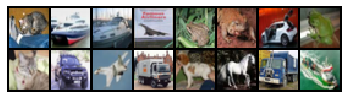

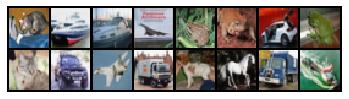

In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images.to(device)
labels.to(device)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
imageshow(torchvision.utils.make_grid(images))
images = Variable(images.cuda())
decoded = autoencoder(images)[1]
imageshow(torchvision.utils.make_grid(decoded.data))

In [9]:
max_epoch = 5
running_loss = 0.0
criterion_class = nn.CrossEntropyLoss()
criterion_auto = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))

for epoch in range(max_epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        encoded, decoded = autoencoder(inputs)
        optimizer.zero_grad()
        outputs = net(encoded)
        auto_loss = criterion_auto(decoded, inputs)
        class_loss = criterion_class(outputs,labels)
        loss = auto_loss+class_loss
        # ============ Forward ============
        #outputs = net(inputs)
        # ============ Backward ============
        loss.backward()
        optimizer.step()
        
        # ============ Logging ============
        running_loss += loss.data
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print("Finished training")

[1,  2000] loss: 1.390
[2,  2000] loss: 0.960
[3,  2000] loss: 0.831
[4,  2000] loss: 0.748
[5,  2000] loss: 0.692
Finished training


In [10]:
AUTO_PATH = './models/auto.pth'
NET_PATH = './models/net.pth'
torch.save(autoencoder.state_dict(), AUTO_PATH)
torch.save(net.state_dict(),NET_PATH)

In [11]:
net = Net()
autoencoder = Autoencoder()
autoencoder.to(device)
net.to(device)
net.load_state_dict(torch.load(NET_PATH))
autoencoder.load_state_dict(torch.load(AUTO_PATH))
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        labels = labels.to(device)
        inputs = Variable(inputs.cuda())
        encoded, decoded = autoencoder(inputs)
        outputs = net(encoded)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %.3f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 71.850 %


In [12]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
y_actual = []
y_pred = []
with torch.no_grad():
    
    for data in testloader:
        inputs, labels = data
        y_actual.extend(labels.data.tolist())
        
        labels = labels.to(device)
        inputs = Variable(inputs.cuda())
        encoded, decoded = autoencoder(inputs)
        outputs = net(encoded)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.data.tolist())
        
        c = (predicted == labels).squeeze()
        for i in range(int(labels.shape[0])):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 78 %
Accuracy of  bird : 64 %
Accuracy of   cat : 49 %
Accuracy of  deer : 64 %
Accuracy of   dog : 60 %
Accuracy of  frog : 81 %
Accuracy of horse : 77 %
Accuracy of  ship : 81 %
Accuracy of truck : 82 %


GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship


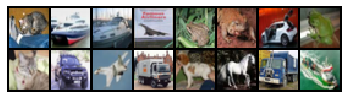

Predicted:    cat  ship  ship plane  frog  frog   car  frog   cat   car  deer truck   dog horse truck  frog


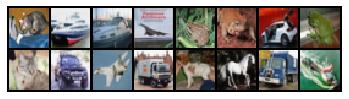

In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images.to(device)
labels.to(device)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
imageshow(torchvision.utils.make_grid(images))
images = Variable(images.cuda())
encoded, decoded = autoencoder(images)
outputs = net(encoded)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(16)))
imageshow(torchvision.utils.make_grid(decoded.data))

In [35]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

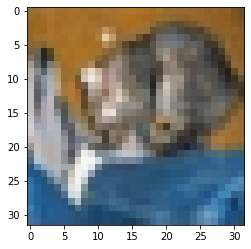

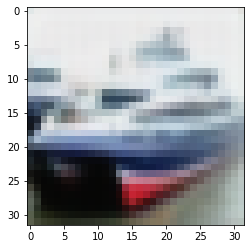

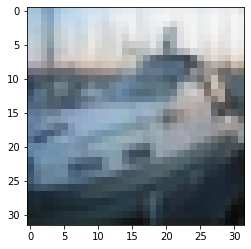

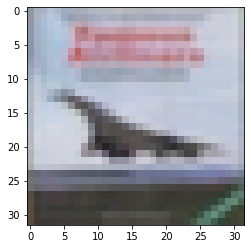

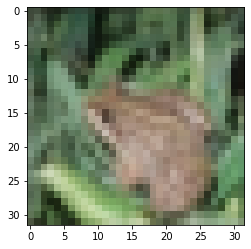

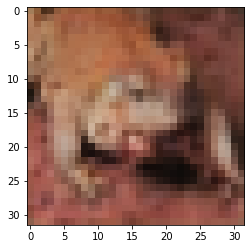

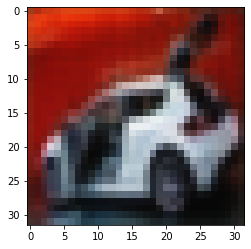

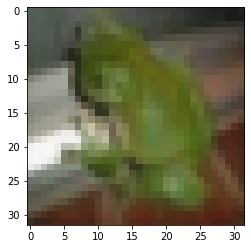

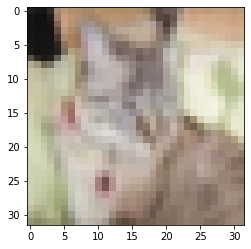

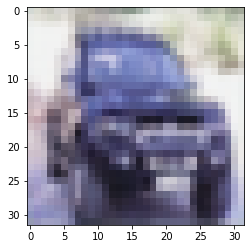

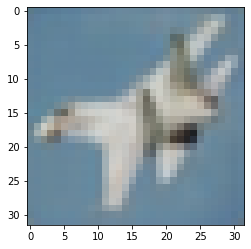

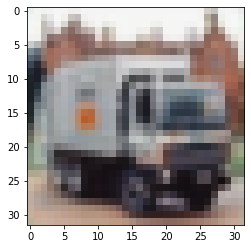

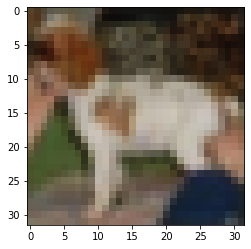

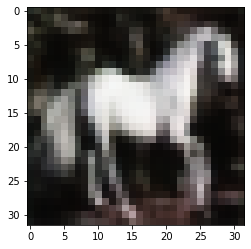

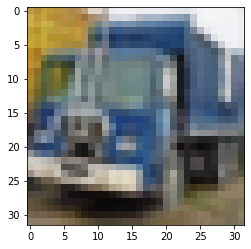

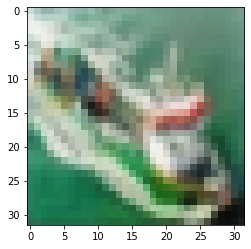

In [14]:
for image in decoded.data:
    image = image.cpu()
    image = np.array(image)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

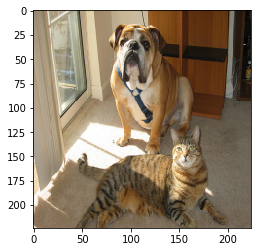

In [19]:
image = Image.open("both.png")
imshow(image)

In [47]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [48]:
features_blobs = []
finalconv_name = 'conv2'
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])


img_tensor = preprocess(image)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable)

classes = {0:'plane', 1:'car', 2:'bird', 3:'cat',
               4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# output the prediction
#for i in range(0, 5):
    #print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('both.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)

RuntimeError: size mismatch, m1: [1 x 44944], m2: [400 x 120] at C:\w\1\s\tmp_conda_3.7_055457\conda\conda-bld\pytorch_1565416617654\work\aten\src\TH/generic/THTensorMath.cpp:752

In [ ]:
class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
    	self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class ModelOutputs():
	""" Class for making a forward pass, and getting:
	1. The network output.
	2. Activations from intermeddiate targetted layers.
	3. Gradients from intermeddiate targetted layers. """
	def __init__(self, model, target_layers):
		self.model = model
		self.feature_extractor = FeatureExtractor(self.model.features, target_layers)

	def get_gradients(self):
		return self.feature_extractor.gradients

	def __call__(self, x):
		target_activations, output  = self.feature_extractor(x)
		output = output.view(output.size(0), -1)
		output = self.model.classifier(output)
		return target_activations, output

def preprocess_image(img):
	means=[0.485, 0.456, 0.406]
	stds=[0.229, 0.224, 0.225]

	preprocessed_img = img.copy()[: , :, ::-1]
	for i in range(3):
		preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
		preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
	preprocessed_img = \
		np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
	preprocessed_img = torch.from_numpy(preprocessed_img)
	preprocessed_img.unsqueeze_(0)
	input = Variable(preprocessed_img, requires_grad = True)
	return input

def show_cam_on_image(img, mask):
	heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
	heatmap = np.float32(heatmap) / 255
	cam = heatmap + np.float32(img)
	cam = cam / np.max(cam)
	cv2.imwrite("cam.jpg", np.uint8(255 * cam))

class GradCam:
	def __init__(self, model, target_layer_names, use_cuda):
		self.model = model
		self.model.eval()
		self.cuda = use_cuda
		if self.cuda:
			self.model = model.cuda()

		self.extractor = ModelOutputs(self.model, target_layer_names)

	def forward(self, input):
		return self.model(input) 

	def __call__(self, input, index = None):
		if self.cuda:
			features, output = self.extractor(input.cuda())
		else:
			features, output = self.extractor(input)

		if index == None:
			index = np.argmax(output.cpu().data.numpy())

		one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
		one_hot[0][index] = 1
		one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
		if self.cuda:
			one_hot = torch.sum(one_hot.cuda() * output)
		else:
			one_hot = torch.sum(one_hot * output)

		self.model.features.zero_grad()
		self.model.classifier.zero_grad()
		one_hot.backward(retain_variables=True)

		grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

		target = features[-1]
		target = target.cpu().data.numpy()[0, :]

		weights = np.mean(grads_val, axis = (2, 3))[0, :]
		cam = np.zeros(target.shape[1 : ], dtype = np.float32)

		for i, w in enumerate(weights):
			cam += w * target[i, :, :]

		cam = np.maximum(cam, 0)
		cam = cv2.resize(cam, (224, 224))
		cam = cam - np.min(cam)
		cam = cam / np.max(cam)
		return cam

In [ ]:
grad_cam = GradCam(model = models.vgg19(pretrained=True), \
					target_layer_names = ["35"], use_cuda=True)


	input = preprocess_image(image)

	# If None, returns the map for the highest scoring category.
	# Otherwise, targets the requested index.
	target_index = None

	mask = grad_cam(input, target_index)

	show_cam_on_image(img, mask)